Mock training for the baseline system which is LSTM. For the dataset, we will use hicaz--sarki datas.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, GRU
from keras.layers import LSTM, Input, Bidirectional
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.metrics import categorical_accuracy
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import SimpleRNN
from keras.layers.wrappers import TimeDistributed
from keras.layers import Convolution1D
from keras.models import load_model
%matplotlib inline 
%config InlineBackend.figure_format = 'retina' # for Mac
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 7]

Using TensorFlow backend.


Download [datas](https://minhaskamal.github.io/DownGit/#/home?url=https://github.com/MTG/SymbTr/tree/master/txt) (which command will download 1000 .txt file from [SymbTR](https://github.com/MTG/SymbTr/tree/master/txt)) and extract from zip. After that, you can follow this notebook.

Upload the datas into panda's dataframe. As I mentioned before, for mock training, we have just used hicaz--sarki datas.

In [2]:
import glob
root_dir = "./txt/"
root_dir = glob.glob(os.path.join(root_dir, "*txt"))

df_hicaz_sarki = pd.concat((pd.read_csv(f, sep="\t") for f in root_dir if "hicaz--sarki" in f))

In [3]:
"""To adjust figure sizes."""

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 7]

We will focus to **generation of Koma53**. Lets look the distribution of Koma53 values.

_Ps. We can also focus KomaAE._

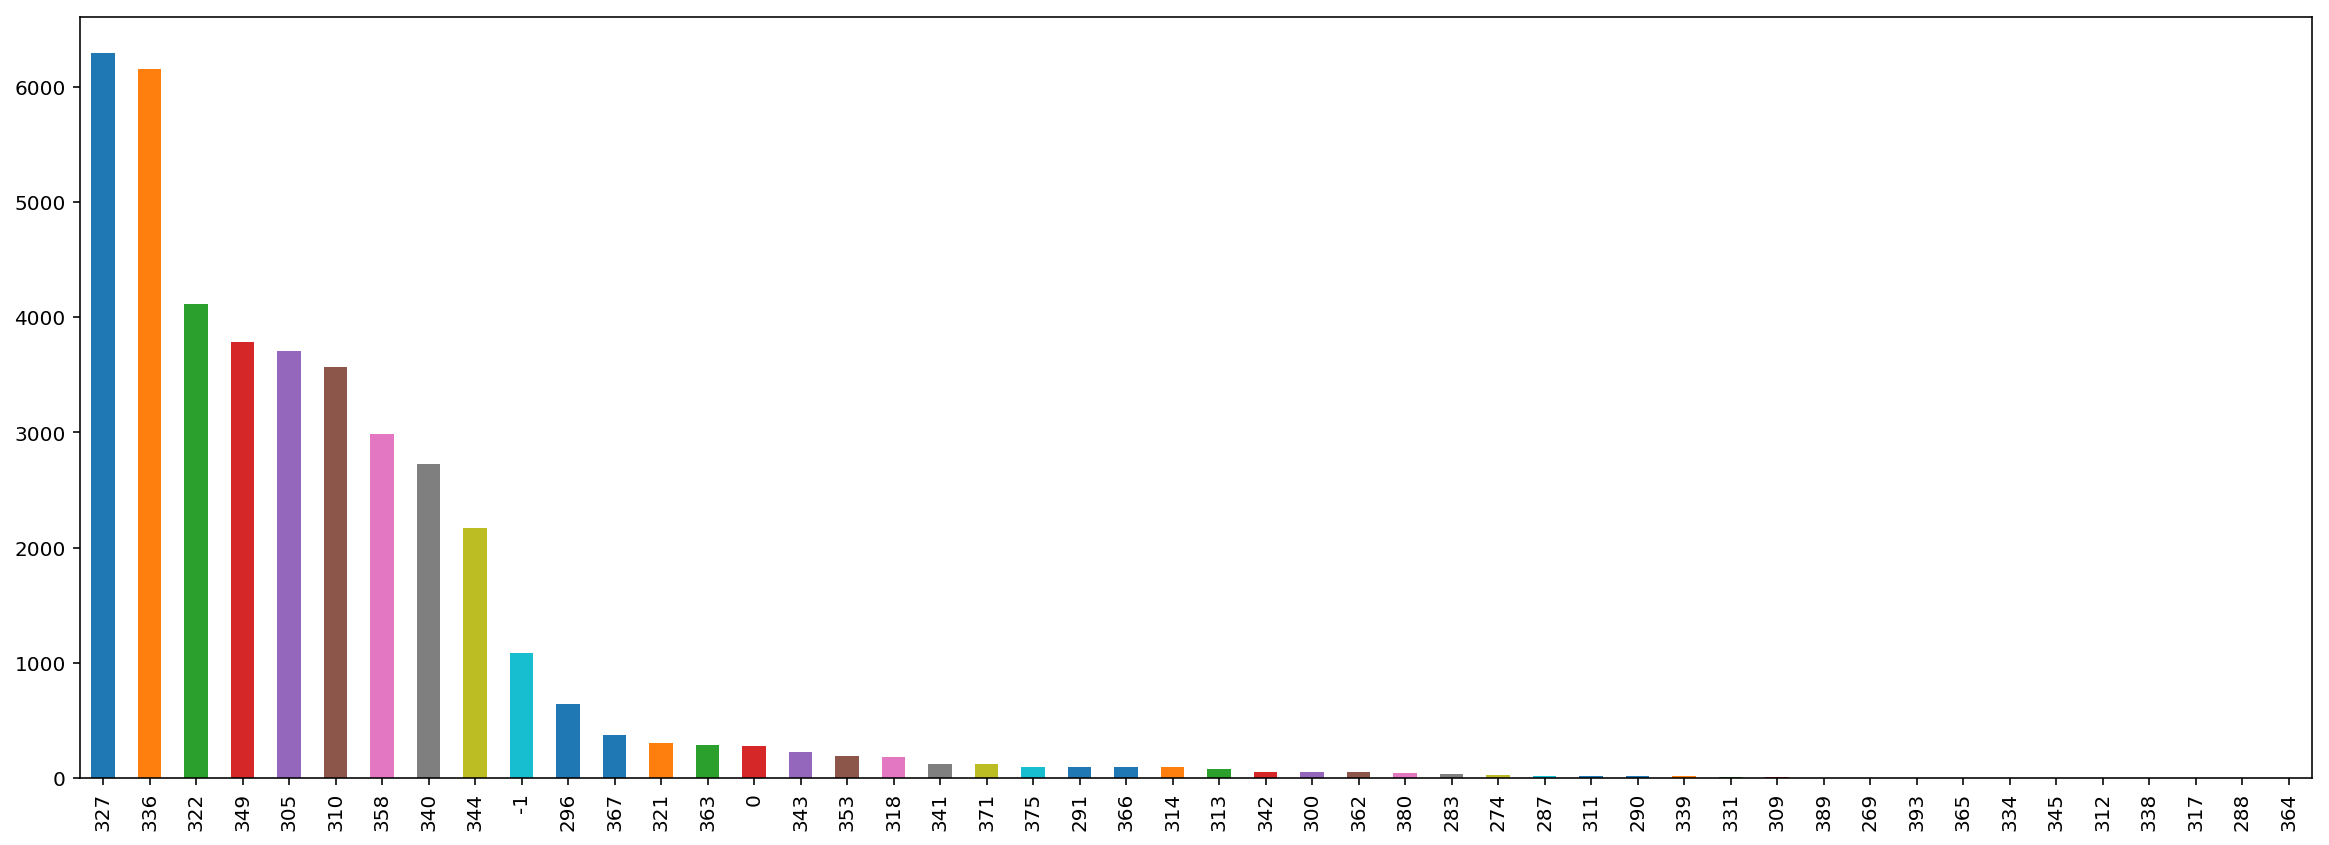

In [4]:
pd.value_counts(df_hicaz_sarki['Koma53']).plot.bar()

In [5]:
total_value = 0
for key, value in pd.value_counts(df_hicaz_sarki['Koma53']).items():
    total_value += value;

print ("Total Koma53 value: ", total_value)

Total Koma53 value:  40149


We will map the uncommon notes into nearest common note to get rid of uncommon note problem. The reason behind that LSTM based system can not learn these uncommon notes. 

Ps. We can also discard these uncommon notes, however, we choose mapping.

In [6]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return (array[idx])

def map_notes(valueCountsOfNote, threshold):
    """This function takes value counts for the Koma53-KomaAe 
    and gives the dict to represent which note should be 
    transformed into which note to get rid of uncommon
    note problem.
    
    Arguments:
    valueCountsOfNote: Value counts of Koma53 or KomaAe 
    threshold: What is the minimum number 
        to kept this note as the common note."""
    
    upThresKeyList = [] # To store, which key has more value than threshold
    mapDict = {} # This dict's keys store the uncommon notes and value store
                 # common notes.
        
    for key, value in valueCountsOfNote.items():
        if (value > threshold):
            upThresKeyList.append(key)
            
    upThresKeyArray = np.asarray(upThresKeyList)
    
    for key, value in valueCountsOfNote.items():
        if key not in upThresKeyList:
            nearNote = find_nearest(upThresKeyArray, key)
            mapDict[key] = nearNote
    return mapDict
            

In [7]:
mappedKoma53Dict = (map_notes(pd.value_counts(df_hicaz_sarki['Koma53']), 250))

In [8]:
df_hicaz_sarki["Mapped Koma53"] = df_hicaz_sarki.Koma53.replace(to_replace=mappedKoma53Dict)

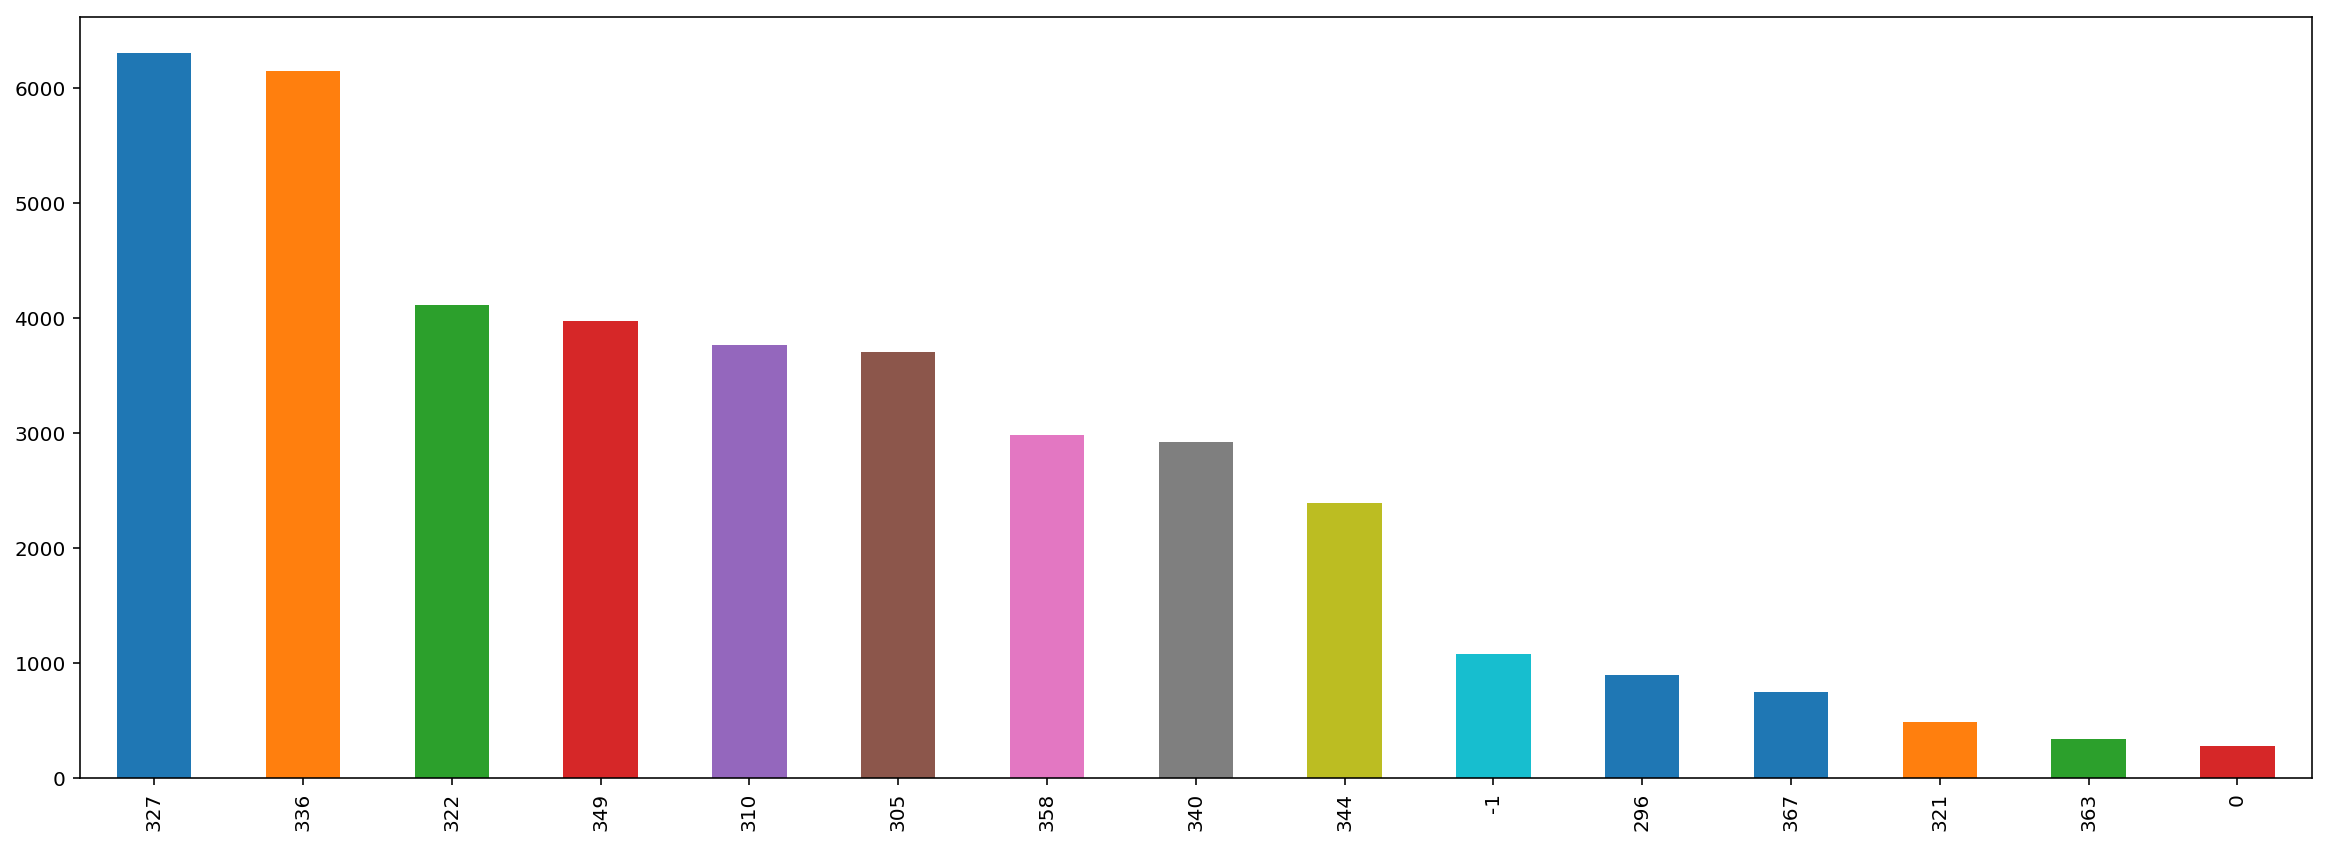

In [9]:
pd.value_counts(df_hicaz_sarki['Mapped Koma53']).plot.bar()

Now, we can move into **generation** part.

In [10]:
note_list = df_hicaz_sarki['Mapped Koma53'].tolist()
note_list = list(map(str, note_list))

In [11]:
save_dir = 'save' # To store trained DL model
vocab_file = os.path.join(save_dir, "words_vocab.pkl")

In [12]:
import collections
from six.moves import cPickle

# Count the number of words
word_counts = collections.Counter(note_list)

# Mapping from index to word : that's the vocabulary
vocabulary_inv = [x[0] for x in word_counts.most_common()]
vocabulary_inv = list(sorted(vocabulary_inv))

# Mapping from word to index
vocab = {x: i for i, x in enumerate(vocabulary_inv)}
words = [x[0] for x in word_counts.most_common()]

# Size of vocabulary
vocab_size = len(words)
print("vocab size: ", vocab_size)

# Save the words and vocabulary as a pickle file
with open(os.path.join(vocab_file), 'wb') as f:
    cPickle.dump((words, vocab, vocabulary_inv), f)

vocab size:  15


In [13]:
"""We need to create two different list. One list include the previous words, 
another list inclued the next word."""

seq_length = 6
sequences_step = 1

sequences = []
next_words = []
for i in range(0, len(note_list) - seq_length, sequences_step):
    sequences.append(note_list[i: i + seq_length])
    next_words.append(note_list[i + seq_length])

print('nb sequences:', len(sequences))

nb sequences: 40143


In [15]:
"""We can not use this type of array directly. So that, we have to modify this data to use with LSTM. We need 
to convert into one-hot vector type array. 

List which includes previous words should have a dimension as number of sequences, number of words in sequences,
number of words in vocabulary. The other list should have a dimension as number of sequences, 
number of words in vocabulary."""

X = np.zeros((len(sequences), seq_length, vocab_size), dtype=np.bool)
y = np.zeros((len(sequences), vocab_size), dtype=np.bool)
for i, sentence in enumerate(sequences):
    for t, word in enumerate(sentence):
        X[i, t, vocab[word]] = 1
    y[i, vocab[next_words[i]]] = 1

In [16]:
def bidirectional_lstm_model(seq_length, vocab_size):
    print('Build LSTM model.')
    model = Sequential()
    model.add(Bidirectional(LSTM(rnn_size, activation="relu", return_sequences=True, 
                                 kernel_initializer='random_normal',
                                    bias_initializer='random_normal'),
                            input_shape=(seq_length, vocab_size)))
    model.add(Dropout(0.7))
    model.add(Bidirectional(LSTM(rnn_size, activation="relu", return_sequences=True, 
                                kernel_initializer='random_normal',
                                    bias_initializer='random_normal')))
    model.add(Dropout(0.7))
    model.add(Bidirectional(LSTM(rnn_size, activation="relu",
                                kernel_initializer='random_normal',
                                    bias_initializer='random_normal')))
    model.add(Dropout(0.3))
    model.add(Dense(vocab_size))
    model.add(Activation('softmax'))
    
    optimizer = Adam(lr=learning_rate)
    callbacks=[EarlyStopping(patience=2, monitor='val_loss')]
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=[categorical_accuracy])
    print("model built!")
    return model

In [17]:
rnn_size = 128 # size of RNN
learning_rate = 0.001

md = bidirectional_lstm_model(seq_length, vocab_size)
md.summary()

Build LSTM model.
model built!
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 6, 256)            147456    
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 256)            0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 6, 256)            394240    
_________________________________________________________________
dropout_2 (Dropout)          (None, 6, 256)            0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 256)               394240    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 15)      

We can **train** the model.

In [18]:
batch_size = 64 # minibatch size
num_epochs = 10 # number of epochs

callbacks=[EarlyStopping(patience=4, monitor='val_loss'),
           ModelCheckpoint(filepath=save_dir + "/" + 'my_model_gen_koma53.{epoch:02d}-{val_loss:.2f}.hdf5',\
                           monitor='val_loss', verbose=0, mode='auto', period=2)]

history = md.fit(X, y,
                 batch_size=batch_size,
                 shuffle=True,
                 epochs=num_epochs,
                 callbacks=callbacks,
                 validation_split=0.1)

md.save(save_dir + "/" + 'my_model_generate_koma53.h5')

Train on 36128 samples, validate on 4015 samples
Epoch 1/10
36128/36128 [==============================] - 73s 2ms/step - loss: 1.9022 - categorical_accuracy: 0.3029 - val_loss: 1.5833 - val_categorical_accuracy: 0.4167
Epoch 2/10
36128/36128 [==============================] - 64s 2ms/step - loss: 1.6176 - categorical_accuracy: 0.4177 - val_loss: 1.4995 - val_categorical_accuracy: 0.4575
Epoch 3/10
36128/36128 [==============================] - 60s 2ms/step - loss: 1.5632 - categorical_accuracy: 0.4442 - val_loss: 1.4713 - val_categorical_accuracy: 0.4767
Epoch 4/10
36128/36128 [==============================] - 64s 2ms/step - loss: 1.5324 - categorical_accuracy: 0.4601 - val_loss: 1.4445 - val_categorical_accuracy: 0.4800
Epoch 5/10
36128/36128 [==============================] - 59s 2ms/step - loss: 1.5054 - categorical_accuracy: 0.4678 - val_loss: 1.4391 - val_categorical_accuracy: 0.4752
Epoch 6/10
36128/36128 [==============================] - 58s 2ms/step - loss: 1.4933 - categori

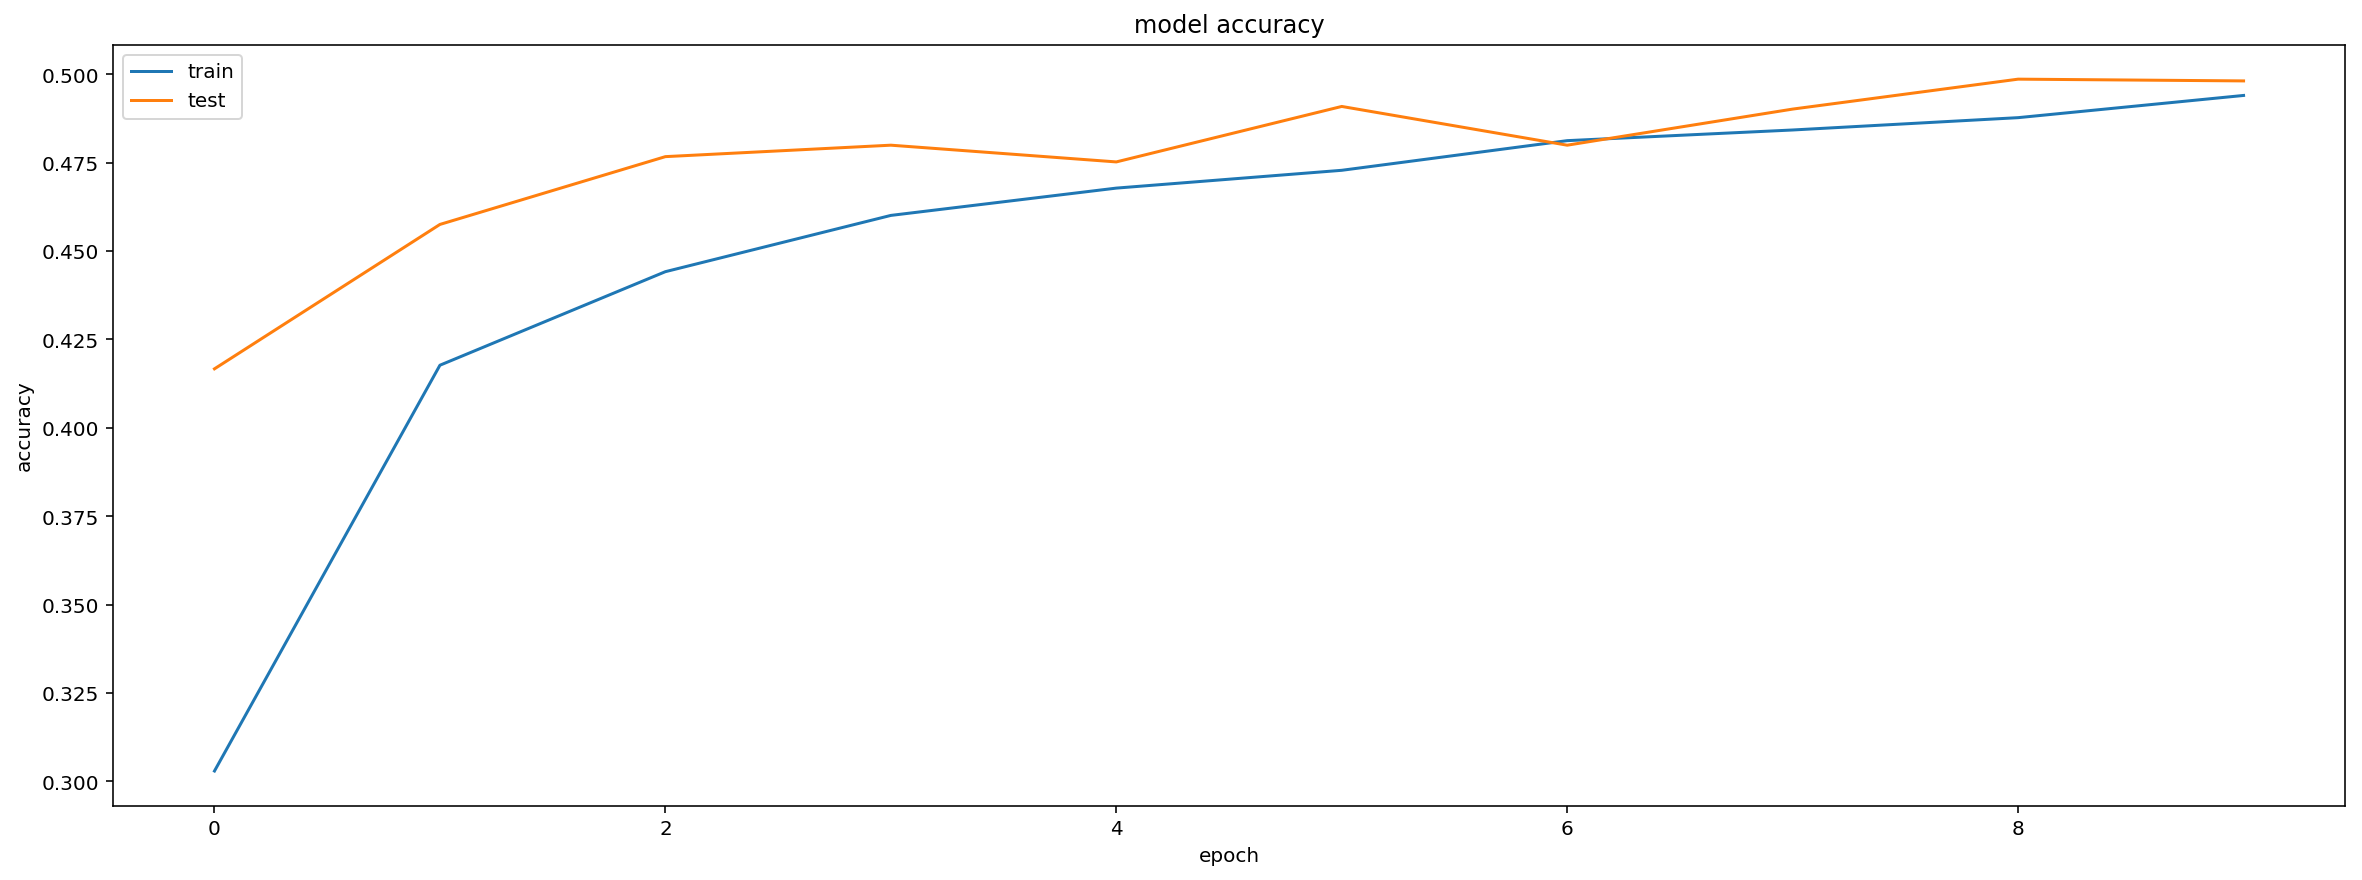

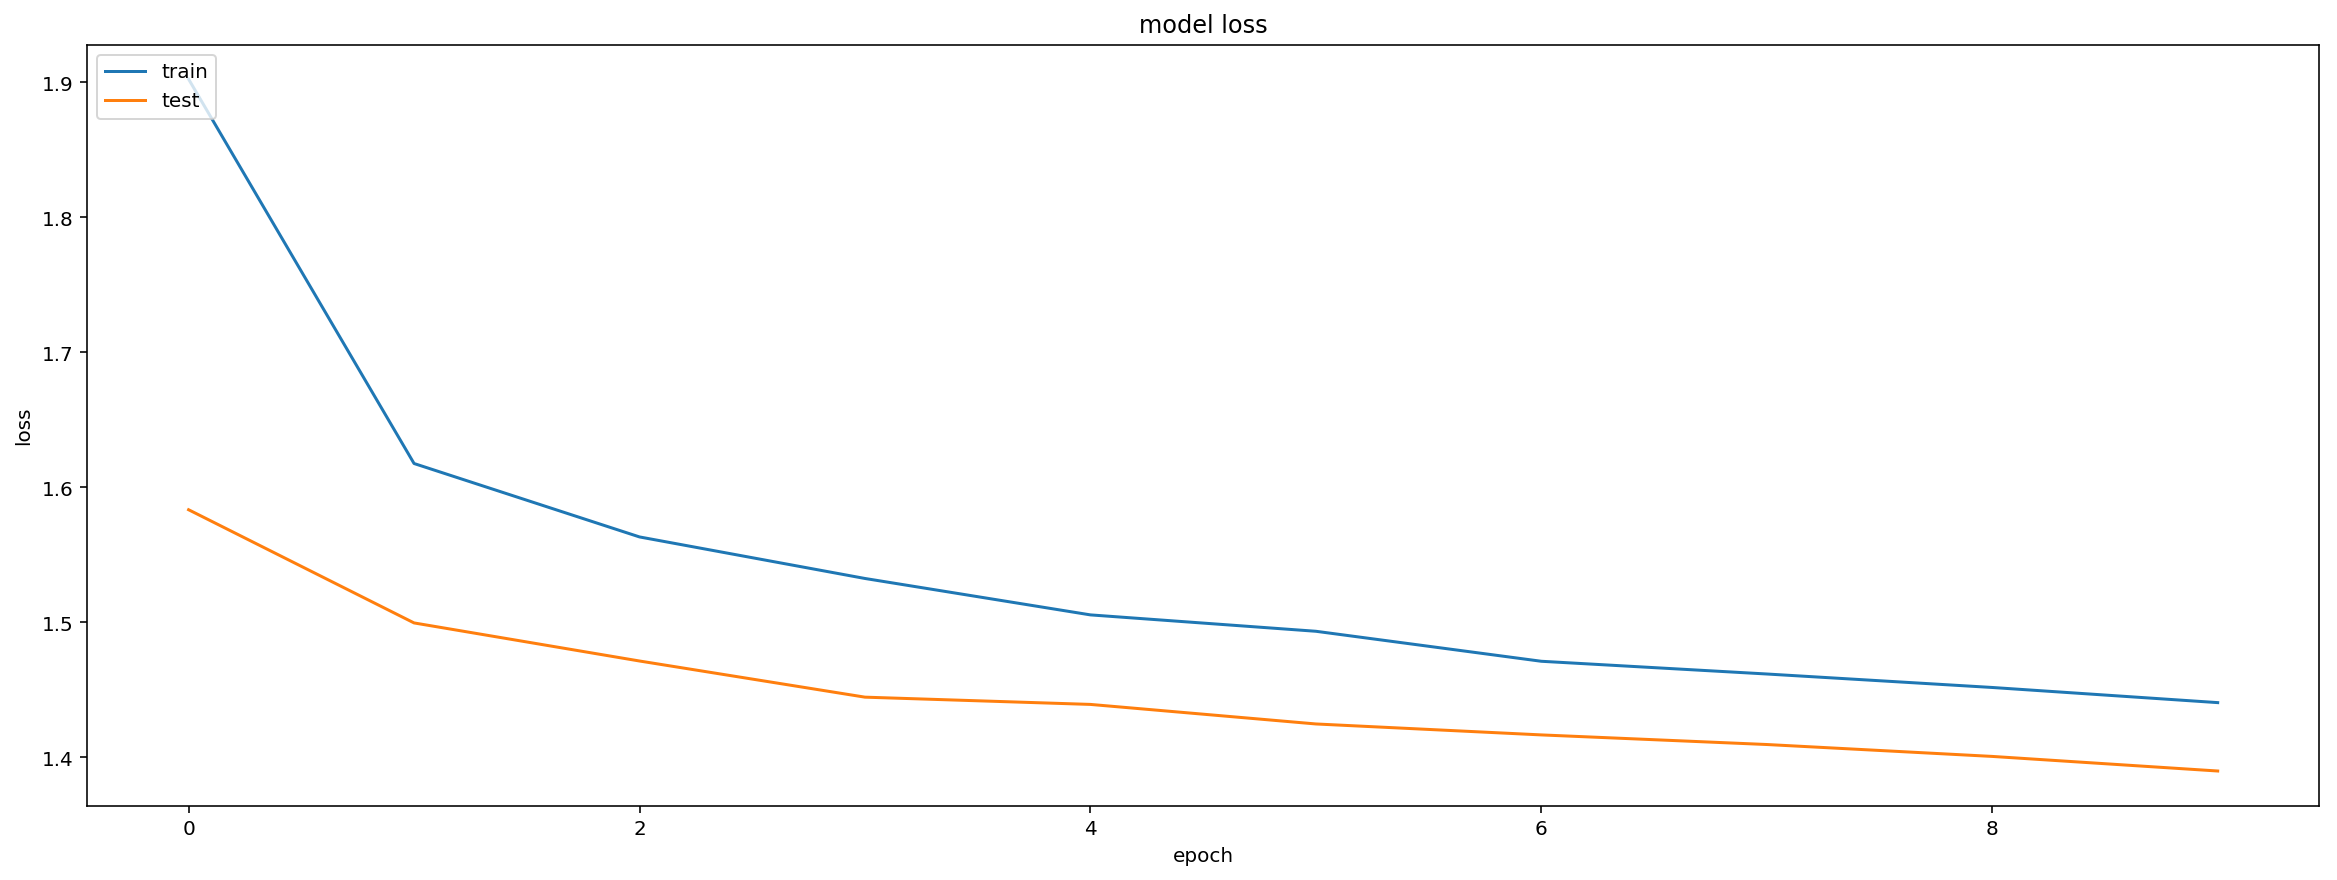

In [19]:
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

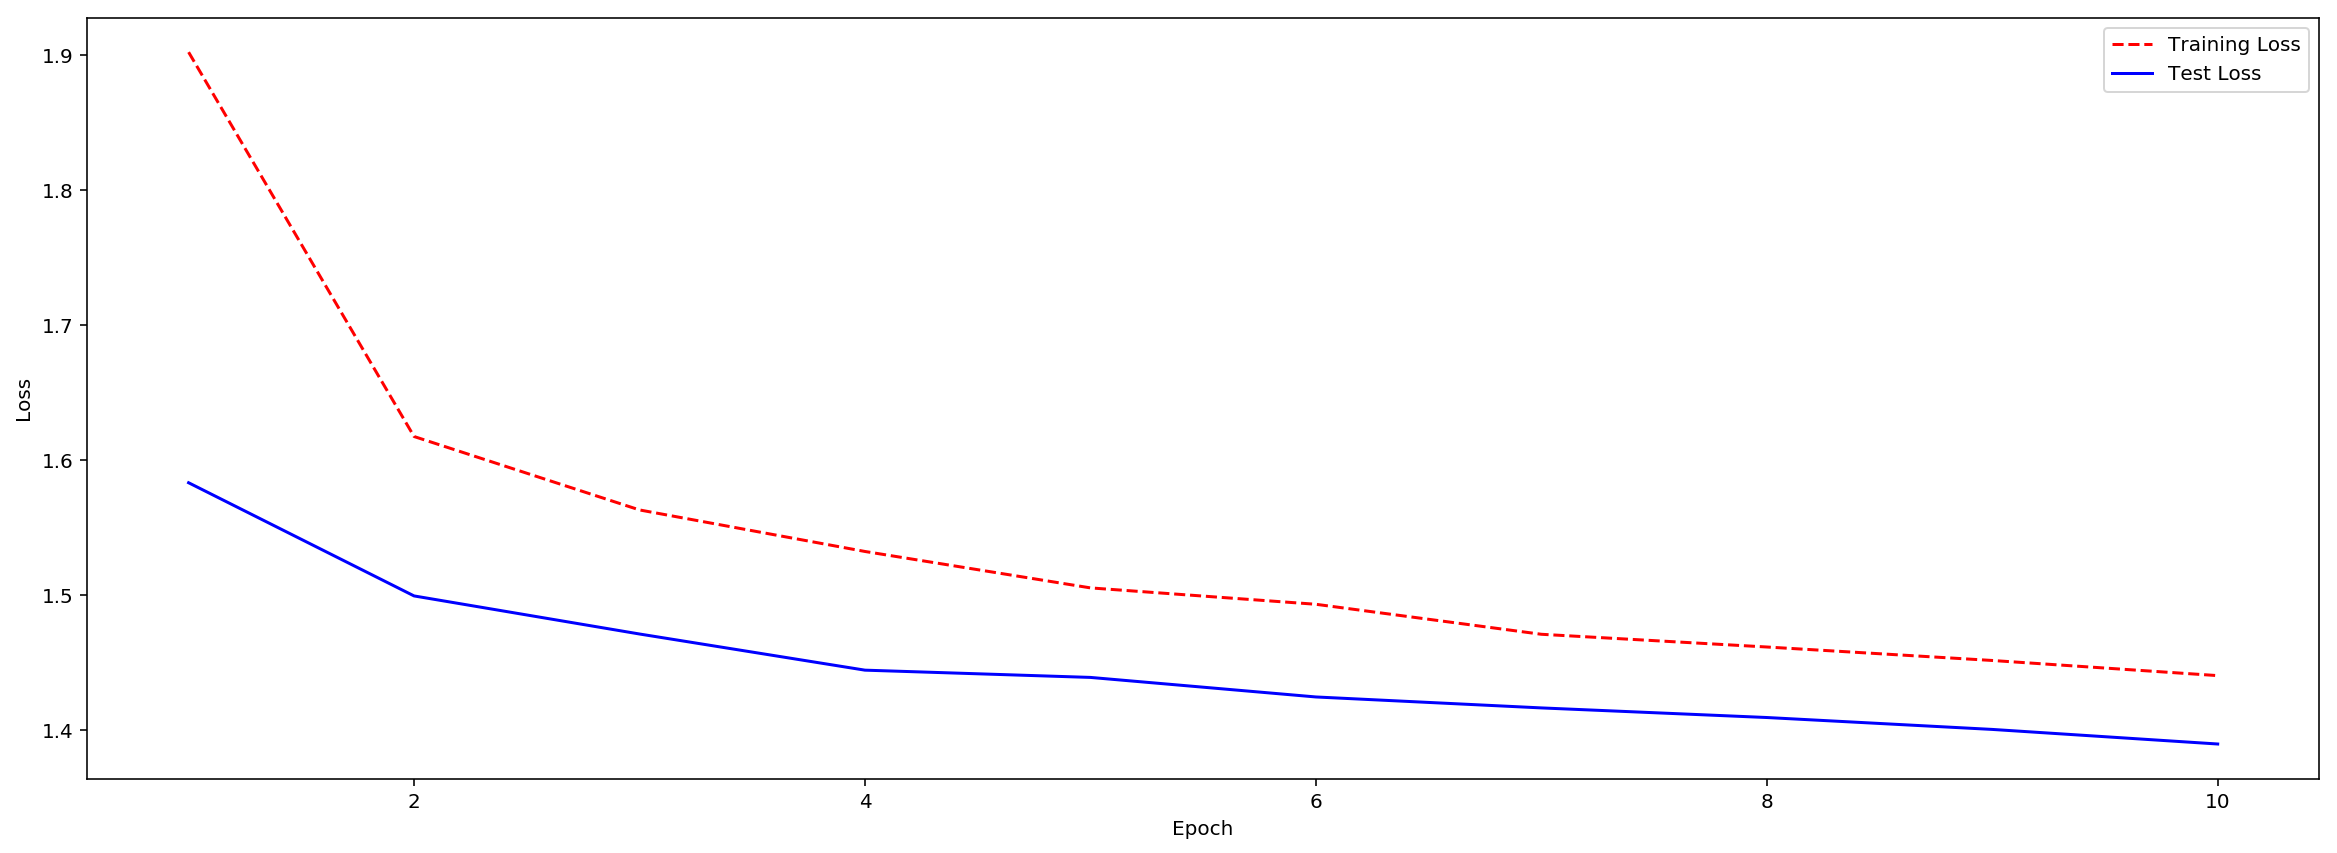

In [20]:
# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [21]:
save_dir = "./save/"

# Load vocabulary
print("loading vocabulary...")
vocab_file = os.path.join(save_dir, "words_vocab.pkl")

with open(os.path.join(save_dir, 'words_vocab.pkl'), 'rb') as f:
        words, vocab, vocabulary_inv = cPickle.load(f)

vocab_size = len(words)

# Load the model
print("loading model...")
model = load_model(save_dir + "/" + 'my_model_generate_sentences.h5')

loading vocabulary...
loading model...


In [22]:
def sample(preds, temperature=1):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [23]:
# Iniatate sentence
seed_sentences = "327 336 305 310 358 310 344"
generated = ''
sentence = []
for i in range (seq_length):
    sentence.append("312")

seed = seed_sentences.split()

for i in range(len(seed)):
    sentence[seq_length-i-1]=seed[len(seed)-i-1]

generated += ' '.join(sentence)
print('Generating text with the following seed: "' + ' '.join(sentence) + '"')

print ()

Generating text with the following seed: "336 305 310 358 310 327"



Now **generate** an example.

In [24]:
words_number = 30000
# Generate the text
for i in range(words_number):
    #create the vector
    x = np.zeros((1, seq_length, vocab_size))
    for t, word in enumerate(sentence):
        x[0, t, vocab[word]] = 1.
    #print(x.shape)

    #calculate next word
    preds = model.predict(x, verbose=0)[0]
    next_index = sample(preds, 0.2)
    next_word = vocabulary_inv[next_index]

    #add the next word to the text
    generated += " " + next_word
    # shift the sentence by one, and and the next word at its end
    sentence = sentence[1:] + [next_word]

# print(generated)

In [25]:
generatedNotesList = []
for singleGenerated in generated.split(" "):
    generatedNotesList.append(int(singleGenerated))

In [26]:
np.asarray(generatedNotesList)
arr = np.asarray(generatedNotesList)
generatedDataFrame = pd.DataFrame({'Koma53':arr})

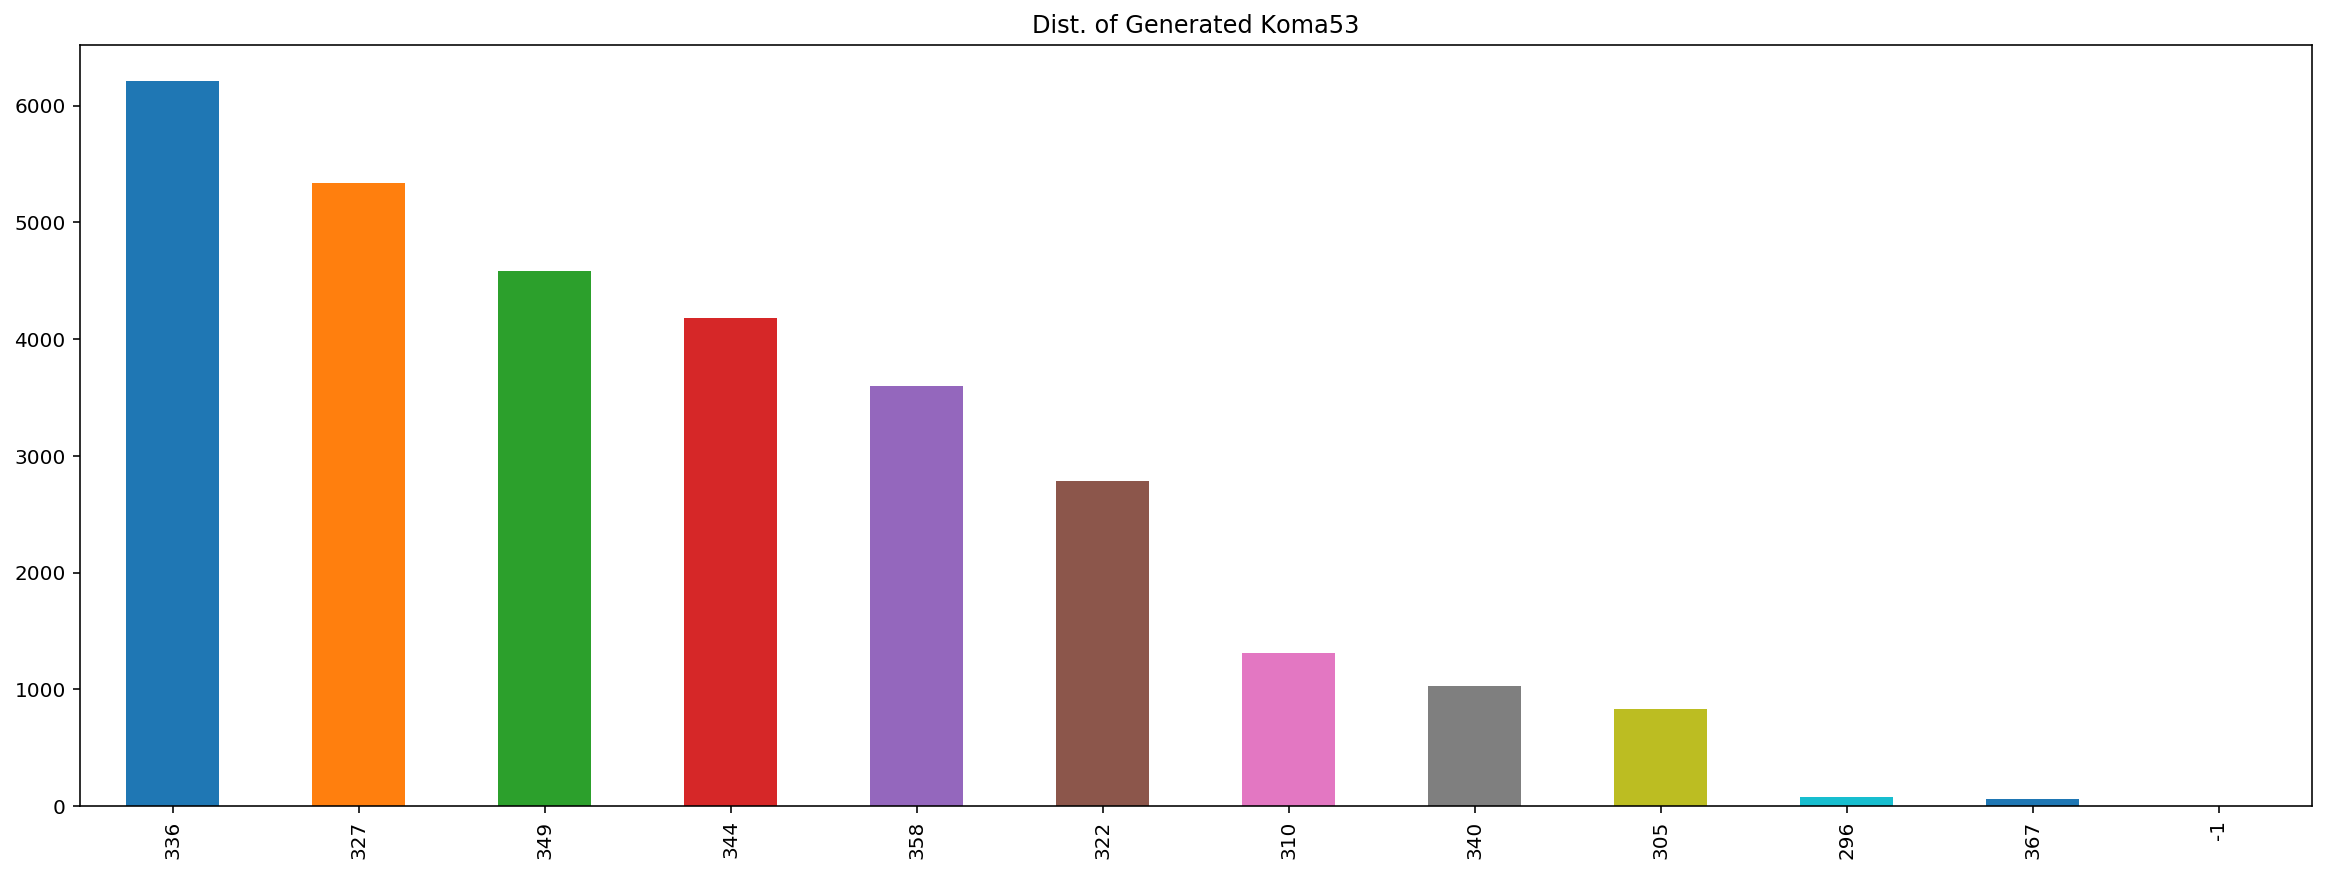

In [35]:
pd.value_counts(generatedDataFrame['Koma53']).plot(kind='bar', title="Dist. of Generated Koma53")

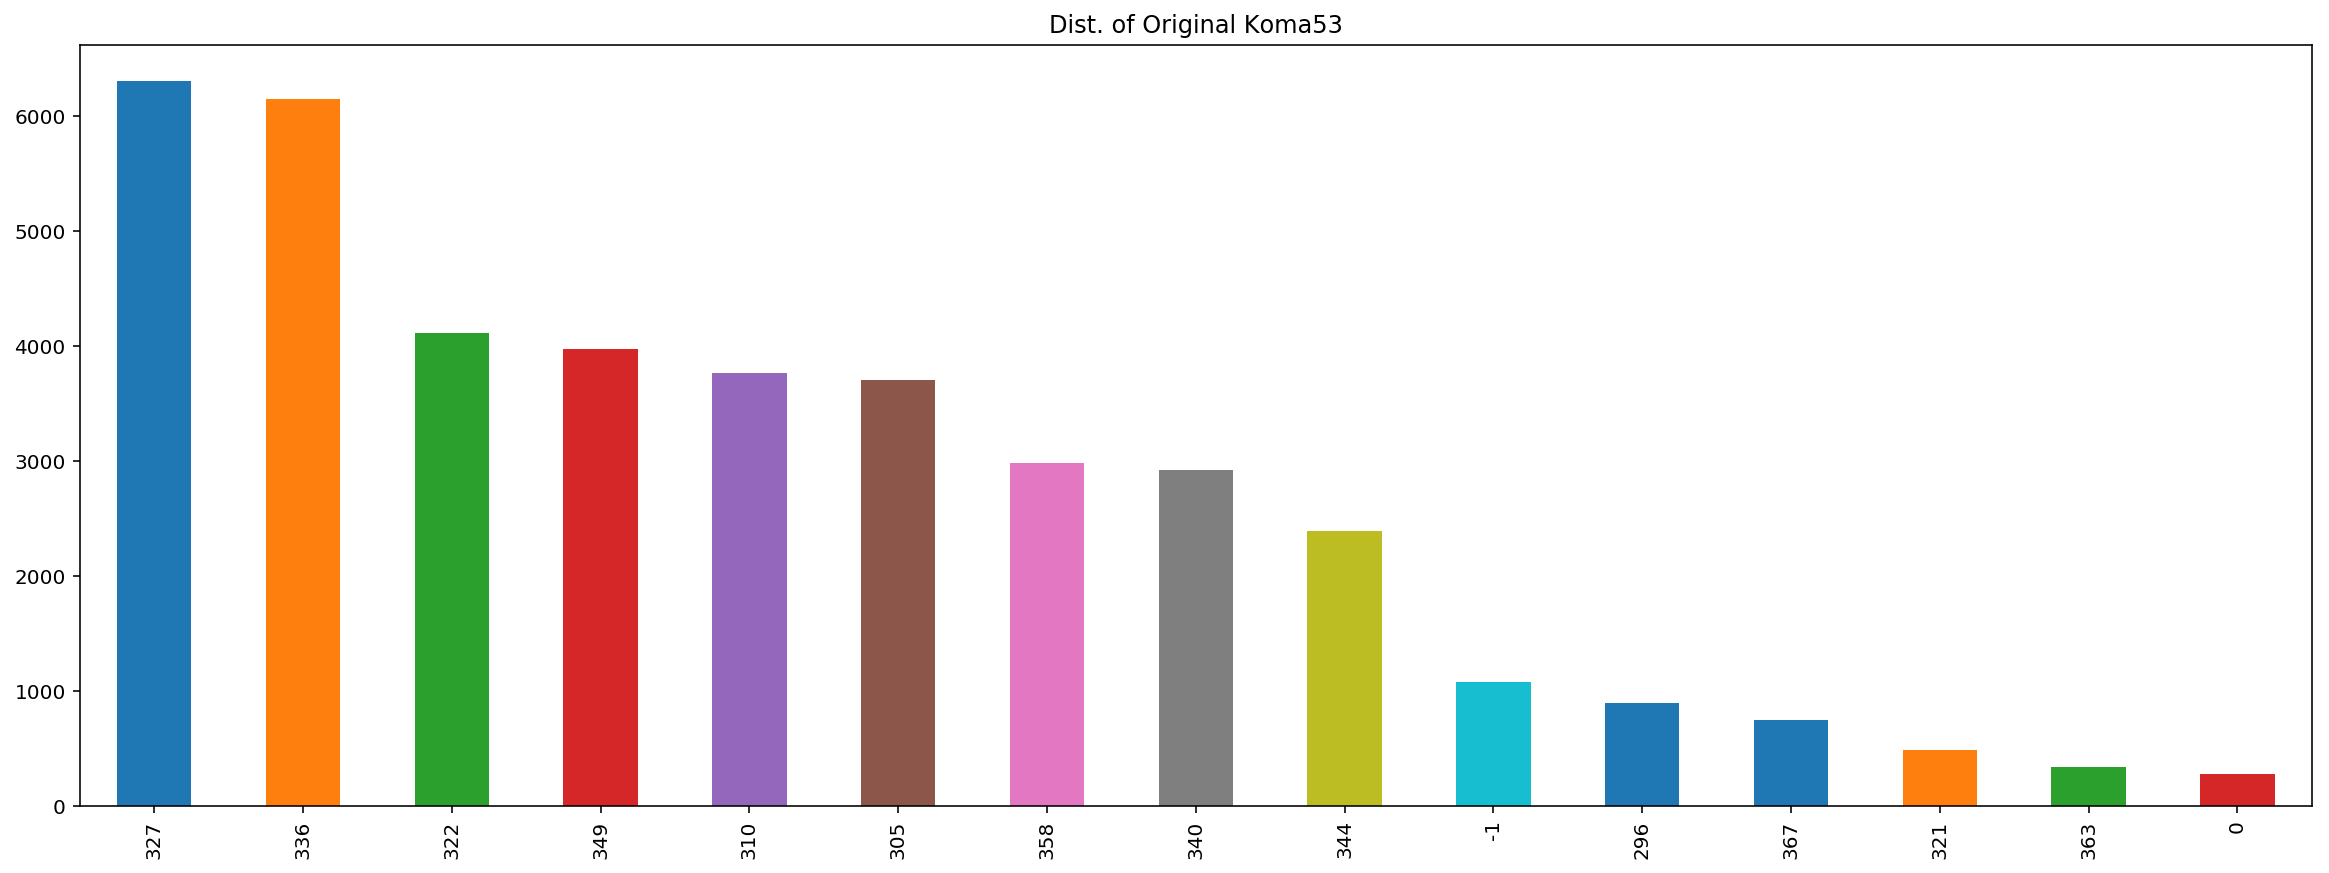

In [36]:
# pd.value_counts(df_hicaz_sarki['Mapped Koma53']).plot.bar()
pd.value_counts(df_hicaz_sarki['Mapped Koma53']).plot(kind='bar', title="Dist. of Original Koma53")

In [37]:
pd.value_counts(generatedDataFrame['Koma53'])

 336    6207
 327    5333
 349    4580
 344    4182
 358    3601
 322    2782
 310    1314
 340    1030
 305     835
 296      80
 367      58
-1         4
Name: Koma53, dtype: int64